# Vegetation detection with autoencoder network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [14]:
from autoencoder import autoencoder_zero

In [12]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [13]:
# RESIZE_TILES = False
# # tile_size = (512, 512)
# tile_size = (128, 128)
# n_channels = 17
# model = unet_zero(len(LABELS)-1, n_channels, *tile_size)

In [23]:
RESIZE_TILES = True
tile_size = (128, 128)
# channels = np.array(range(11))
channels = np.array([0, 1, 2, 3, 5, 6])
n_channels = len(channels)
# labels = np.array(range(len(LABELS)))
labels = np.array([0, 5, 6])
n_labels = len(labels)

model = autoencoder_zero(n_labels, n_channels, *tile_size)

In [24]:
channels, labels

(array([0, 1, 2, 3, 5, 6]), array([0, 5, 6]))

In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 6, 128, 128)   0                                            
____________________________________________________________________________________________________
zeropadding2d_30 (ZeroPadding2D) (None, 6, 130, 130)   0           input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_37 (Convolution2D) (None, 64, 128, 128)  3520        zeropadding2d_30[0][0]           
____________________________________________________________________________________________________
batchnormalization_33 (BatchNorm (None, 64, 128, 128)  512         convolution2d_37[0][0]           
___________________________________________________________________________________________

In [26]:
import os
from keras.optimizers import Adam, Nadam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

In [27]:
from glob import glob
all_train_tiles = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_tiles = np.array([s[len(TRAIN_DATA)+1:] for s in all_train_tiles])

In [28]:
all_train_tiles[0]

'6010_1_2_0_0.tif'

In [29]:
from sklearn.model_selection import train_test_split 

# TRAIN ON N TILES
n_tiles = 256
if n_tiles > 0:
    train_tiles, val_tiles = train_test_split(all_train_tiles[:n_tiles], test_size=0.3)
else:
    train_tiles, val_tiles = train_test_split(all_train_tiles, test_size=0.3)
    
print len(train_tiles), len(val_tiles)

179 77


In [30]:
def normalize_image(img_data, max_value=1.0):
    if RESIZE_TILES:
        out = cv2.resize(img_data, dsize=tile_size, interpolation=cv2.INTER_CUBIC).astype(np.float32)
        if len(out.shape) == 2:
            out = out[:, :, None]
    else:
        out = img_data.astype(np.float32)

    if max_value > 1.0:  
        out = normalize(out, 0.01, 99.9)        
    
    out = out.transpose([2,0,1])
    return out


def make_ratios_vegetation(img_17b):
    """
        Method creates an image of all possible band ratios
        
        - panchromatic[0] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
        - panchromatic[0] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[1] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[2] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[6] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[6] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[7] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[7] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[7] / MS[10:17] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[8] / MS[4] = Trees, Crops, Misc manmade structures (of trees) 
        - MS[8:17] / MS[5] = Trees, Crops, Misc manmade structures (of trees) 
    """
    h, w, n = img_17b.shape
    
    out_n = 23
    out = np.zeros((h, w, out_n), dtype=np.float32)
    def _ratio(i, j):
        return img_17b[:,:,i] / (img_17b[:,:,j] + 0.00001)
        
    out[:,:,0] = _ratio(0, 5)
    out[:,:,1] = _ratio(0, 4)
    out[:,:,2] = _ratio(1, 5)
    out[:,:,3] = _ratio(2, 5)
    out[:,:,4] = _ratio(6, 4)
    out[:,:,5] = _ratio(6, 5)
    out[:,:,6] = _ratio(7, 4)
    out[:,:,7] = _ratio(7, 5)
    out[:,:,8] = _ratio(7, 10)
    out[:,:,9] = _ratio(7, 11)
    out[:,:,10] = _ratio(7, 12)
    out[:,:,11] = _ratio(7, 13)
    out[:,:,12] = _ratio(7, 14)
    out[:,:,13] = _ratio(7, 15)
    out[:,:,14] = _ratio(7, 16)
    out[:,:,15] = _ratio(8, 4)
    out[:,:,16] = _ratio(9, 5)
    out[:,:,17] = _ratio(10, 5)
    out[:,:,18] = _ratio(11, 5)
    out[:,:,19] = _ratio(12, 5)
    out[:,:,20] = _ratio(13, 5)
    out[:,:,21] = _ratio(14, 5)
    out[:,:,22] = _ratio(15, 5)
    return out


def generate_images(train_tiles, batch_size):
    while True:
        n = len(train_tiles)
        n_batches = n // batch_size
        random_indices = np.arange(n)
        np.random.shuffle(random_indices)
        for i in range(n_batches):
            end = min((i+1)*batch_size, n) 
            batch_indices = random_indices[batch_size*i:end]
            X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
            Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
            for j, tile_id in enumerate(train_tiles[batch_indices]):
                x = get_image_tile_data(os.path.join(TRAIN_DATA,tile_id))
                y = get_image_tile_data(os.path.join(TRAIN_LABEL_TILES,tile_id))

                x = make_ratios_vegetation(x)
                
                if n_labels < len(LABELS) - 1:
                    y = y[:,:,labels]
                if n_channels < 17:
                    x = x[:,:,channels]

                x = normalize_image(x, 2.0**10)
                y = normalize_image(y)     
                
                X[j,:,:,:] = x
                Y[j,:,:,:] = y 
                
            yield (X, Y)

(5, 6, 128, 128) (5, 3, 128, 128)
0.0 1.0 0.0 255.0


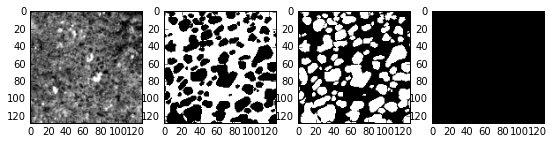

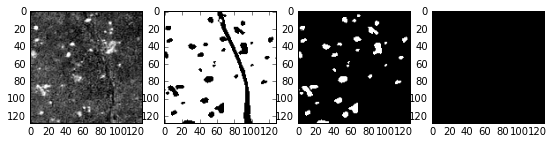

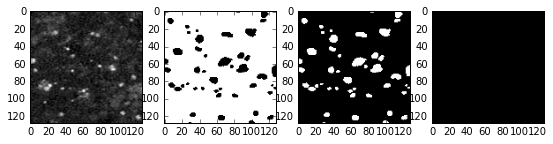

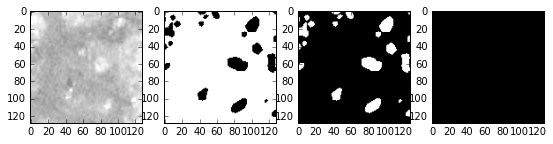

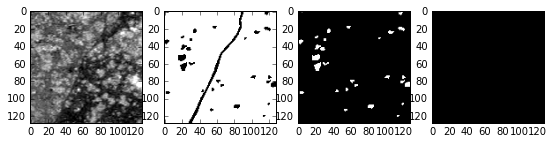

In [31]:
batch_size = 5
for X, Y in generate_images(train_tiles, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(261)
        display_img_1b(X[i,1,:,:])
        for j in range(n_labels):
            plt.subplot(2,6,j+2)
            display_img_1b(Y[i,j,:,:])

    break

In [32]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint('weights/ae_zero.h5', monitor='loss', save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [33]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

We have 25 images splitted into 64 tiles. It gives 1600 tiles to train on.
Train/test split with test size 0.3 gives: 1120 and 480 number of tiles.
Assembling 32 tiles in a batch, we obtain 35 batches for training tiles and 15 batches for validation.

In [34]:
# from keras.callbacks import RemoteMonitor
# rmon = RemoteMonitor(root='http://localhost:9000', path='/publish/epoch/end/', field='data', headers={'Content-Type': 'application/json', 'Accept': 'application/json'})

In [35]:
foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 16
samples_per_epoch = foo(len(train_tiles))
nb_val_samples = foo(len(val_tiles))


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_tiles, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=20,
    validation_data=generate_images(val_tiles, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

16 160 77
Epoch 1/20
140s - loss: 229.2637 - jaccard_coef: 4.2680e-05 - jaccard_coef_int: 2.0845e-14 - acc: 0.3120 - val_loss: 226.3158 - val_jaccard_coef: 4.5791e-05 - val_jaccard_coef_int: 2.0843e-14 - val_acc: 0.2701
Epoch 2/20
117s - loss: 230.9713 - jaccard_coef: 4.3936e-05 - jaccard_coef_int: 2.0845e-14 - acc: 0.3140 - val_loss: 227.7022 - val_jaccard_coef: 4.5370e-05 - val_jaccard_coef_int: 2.0843e-14 - val_acc: 0.2321
Epoch 3/20
118s - loss: 226.9593 - jaccard_coef: 4.8385e-05 - jaccard_coef_int: 2.0845e-14 - acc: 0.2670 - val_loss: 221.2867 - val_jaccard_coef: 4.6686e-05 - val_jaccard_coef_int: 2.0845e-14 - val_acc: 0.0744
Epoch 4/20
119s - loss: 224.2708 - jaccard_coef: 5.7536e-05 - jaccard_coef_int: 2.0846e-14 - acc: 0.1532 - val_loss: 218.9317 - val_jaccard_coef: 4.6873e-05 - val_jaccard_coef_int: 2.0844e-14 - val_acc: 0.2791
Epoch 5/20
119s - loss: 228.2300 - jaccard_coef: 7.1309e-05 - jaccard_coef_int: 2.0845e-14 - acc: 0.1519 - val_loss: 224.3129 - val_jaccard_coef: 5.25

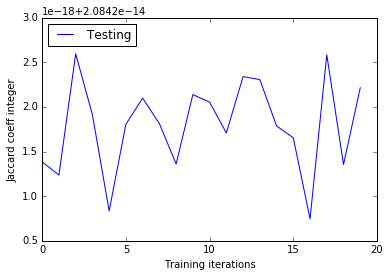

In [36]:
plt.plot(history.history['val_jaccard_coef_int'])
plt.ylabel('Jaccard coeff integer')
# plt.plot(history.history['val_jaccard_coef'])
# plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [37]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5, 3, 128, 128) 3.93127e-06 0.0013662


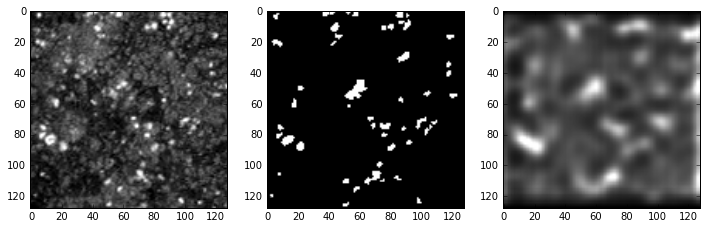

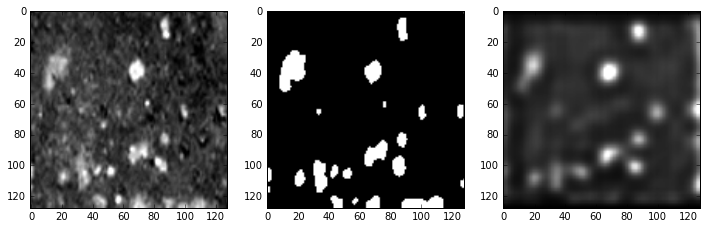

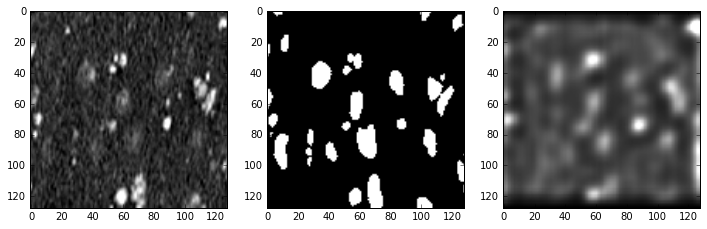

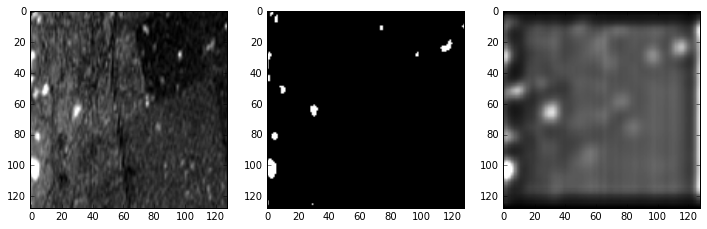

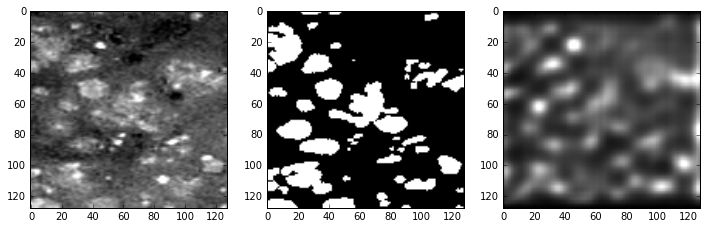

In [38]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        _plot(X, Y, Y_pred, i)

#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)
    break


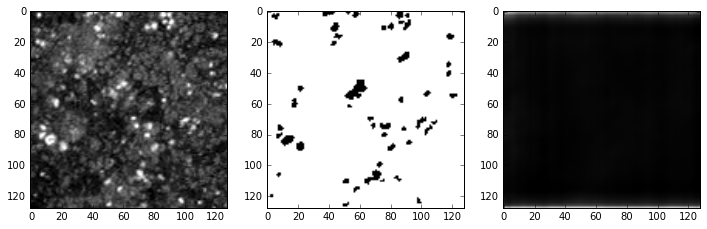

In [39]:
_plot(X, Y, Y_pred, 0, 0)

In [22]:
y = Y_pred[0,1,:,:]
print y.min(), y.max()

2.11063e-12 0.000444466
